<a name="top"><h1>Práctica 2: StackOverFlow </h1> </a>

<strong>Técnicas de Predicción: Series temporales</strong><br />
<strong>Master Universitario en Ciencia de Datos</strong>

<p>&nbsp;</p>

<p style="text-align:right">V&iacute;ctor Viloria V&aacute;zquez (<em>victor.viloria@cunef.edu</em>)</p>

<hr style="border:1px solid gray">

## Estructura

[1. Introducción](#introduccion) 

   - Objetivos específicos
    

[2. Importación de librerias](#importacion)

[3. Tratamiento de datos](#tratamiento)

[4. Graficación de la serie](#graficacion)

   - Análisis de estacionalidad
    
    
[5. Modelo ETS - Suavizado Exponencial (Automático)](#ets)
          
     
[6. Modelo ARIMA (Autorregresivo integrado de media móvil)](#arima)


[7. Modelo 4Theta](#4theta)

[8. Modelo TBATS](#tbats)

[9. Predicción de 12 meses fuera de la muestra](#prediccion)

[10. Conclusiones Generales](#conclusiones)


<hr style="border:1px solid gray">

## <a name="introduccion"> 1. Introducción </a>

Para la realización de esta segunda práctica disponemos del dataset `StackOverflow.csv`,en el encontramos datos sobre las nuevas preguntas que se realizan mensualmente para los diferentes lenguajes de programación. En este documento realizaremos un análisis de la evolución de las preguntas relacionadas con 'Matlab' y construiremos un modelo predictivo de series temporales.

### 1.1. Objetivos específicos

- Analizar los datos de MATLAB, entre otros análisis, se debe graficar la serie, estudiar la estacionalidad y la estacionariedad.


- Se debe separa la muestra en tres partes entrenamiento, validación(12 meses) y test (6 meses). Cuando no sea necesaria la validación la muestra de test debe ser de 6 meses.


- Debemos buscar el mejor modelo predictivo entre los siguientes:

    - ETS
    - ARIMA
    - 4Theta
    - TBATS
    
    
- Una vez seleccionado el modelo se debe realizar una predicción de 12 meses fuera de la muestra.

## <a name="importacion">2. Importación de las librerias </a>

Importamos las librerias necesarias para la realización de la práctica:

In [4]:
# Ignore warnings.

import warnings
warnings.filterwarnings('ignore')

# Import general libraries.

import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Import libraries for time series analysis.

import statsmodels.api as sm # Time series analysis.
from sktime.forecasting.base import ForecastingHorizon # Forecasting Horizon
from sktime.utils.plotting import plot_series # Plot series
from sktime.forecasting.model_selection import temporal_train_test_split # Train and test split
from sktime.forecasting.ets import AutoETS # ETS Model.
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error # % MAE
from sktime.performance_metrics.forecasting import MeanSquaredError # MAE
from sktime.forecasting.exp_smoothing import ExponentialSmoothing # ETS manual model.
from sktime.transformations.series.boxcox import LogTransformer # Logarítmic transformation.
from sktime.forecasting.arima import AutoARIMA # ARIMA model.
from statsmodels.tsa.seasonal import seasonal_decompose # Decomposition.
from darts.models import Theta, FourTheta # Theta y 4Theta models.
from darts.utils.utils import SeasonalityMode, TrendMode, ModelMode # 4Theta basics.
from darts.metrics import mape # MAPE.
from darts.models import TBATS # TBATS model.
from darts import TimeSeries # TimeSeries Format.


## <a name="tratamiento">  3. Tratamiento de datos

Comenzamos importando los datos de `StackOverflow.csv`

In [3]:
# Load the data, separated by ','.

stack_df = pd.read_csv('../data/StackOverflow.csv', sep = ',')

# Display the first 5 rows.

stack_df.head()


,month,nltk,spacy,stanford-nlp,python,r,numpy,scipy,matlab,machine-learning,...,Plato,Sympy,Flair,stanford-nlp.1,pyqt,Nolearn,Lasagne,OCR,Apache-spark-mlib,azure-virtual-machine
0,09-Jan,0,0,0,631,8,6,2,19,8,...,0,1,0,0,5,0,0,5,0,0
1,09-Feb,1,0,0,633,9,7,3,27,4,...,0,0,0,0,5,0,0,11,0,0
2,09-Mar,0,0,0,766,4,4,2,24,3,...,0,0,0,0,7,0,0,2,0,0
3,09-Apr,0,0,0,768,12,6,3,32,10,...,0,0,0,0,11,0,0,5,0,0
4,09-May,1,0,0,1003,2,7,2,42,7,...,0,0,0,0,10,0,0,3,0,0


Convertimos la columna 'month' a formato de fecha y la fijamos como índice.

In [4]:
# Convert the column 'month' to datetime format.

stack_df['month'] = pd.to_datetime(stack_df['month'], format="%y-%b")

# Convert the column 'month' to index.

stack_df = stack_df.set_index('month') 

Comprobamos si existe algún valor nulo dentro de la columna de Matlab, que es la que nos interesa en este caso.

In [6]:
# Check if there are null values.

n_nulos = stack_df.matlab.isnull().sum()

# Print the number of null values.

print('Hay '+ str(n_nulos) + ' valores nulos en la columna de Matlab')

Hay 0 valores nulos en la columna de Matlab


## <a name="graficacion">  4. Graficación de la serie temporal </a>

Representamos graficamente la serie temporal para visualizar sus características:

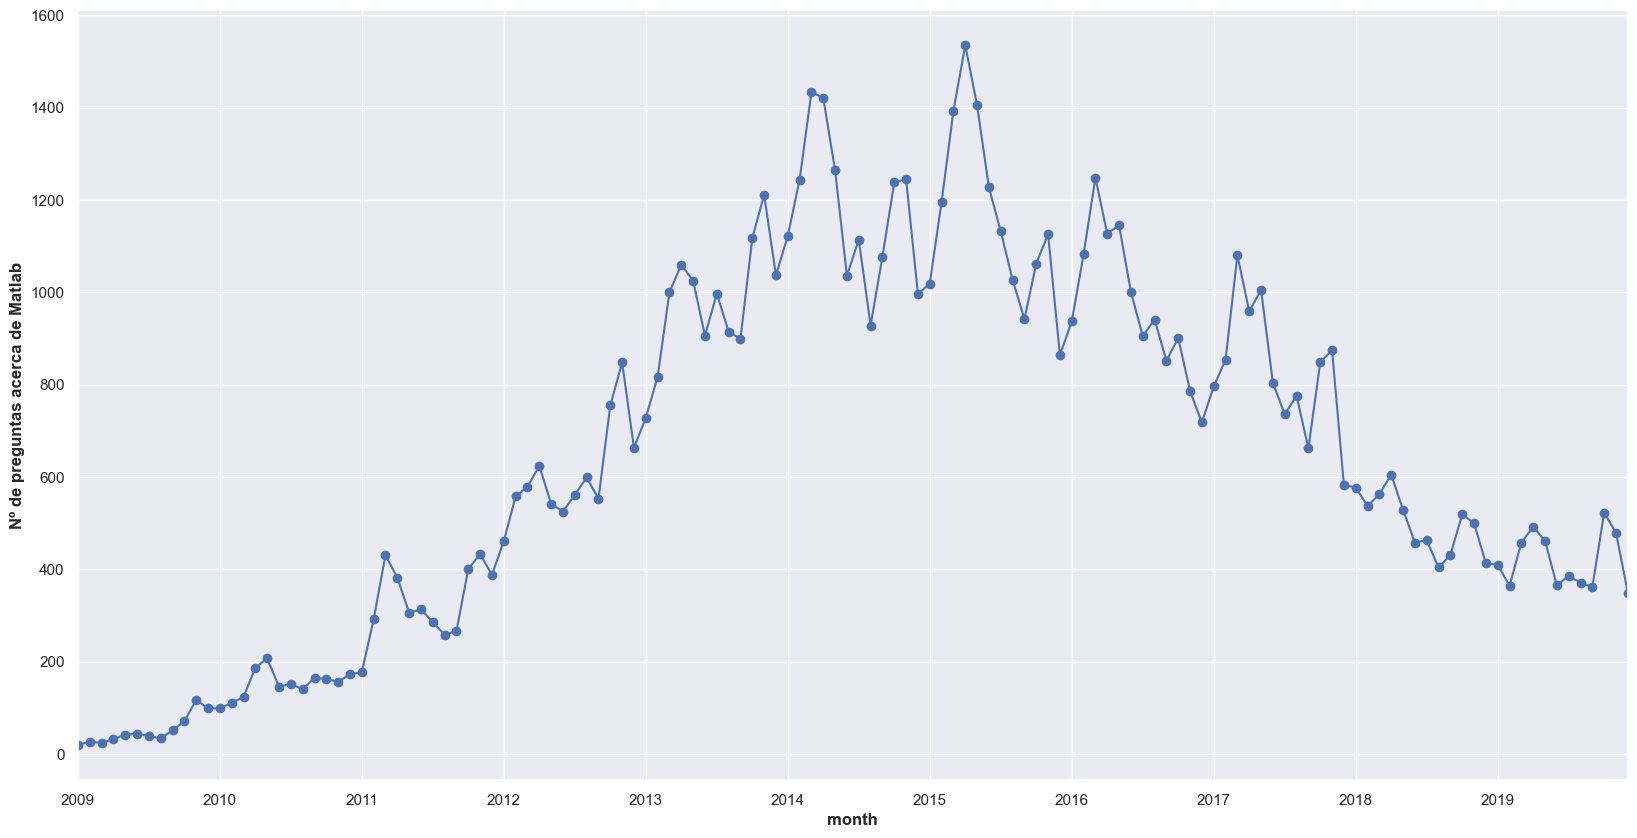

In [7]:
# Graph the number of questions about Matlab.

sns.set(rc={'figure.figsize':(20, 10)})
ax = stack_df.matlab.plot(marker='o', linestyle='-')
ax.set_ylabel('Nº de preguntas acerca de Matlab')

plt.show()

Observamos como la gráfica tiene una tendencia alcista hasta mediaddos de 2015, y a partir de ese momento la tendencia se vuelve bajista. Probablemente debido a la aparición de nuevos lenguajes/softwares más completos que han dejado obsoleto a Matlab provocando una migración de usuarios.

Descomponemos la gráfica para comprobar si existe tendencia, estacionalidad y componente estacional;

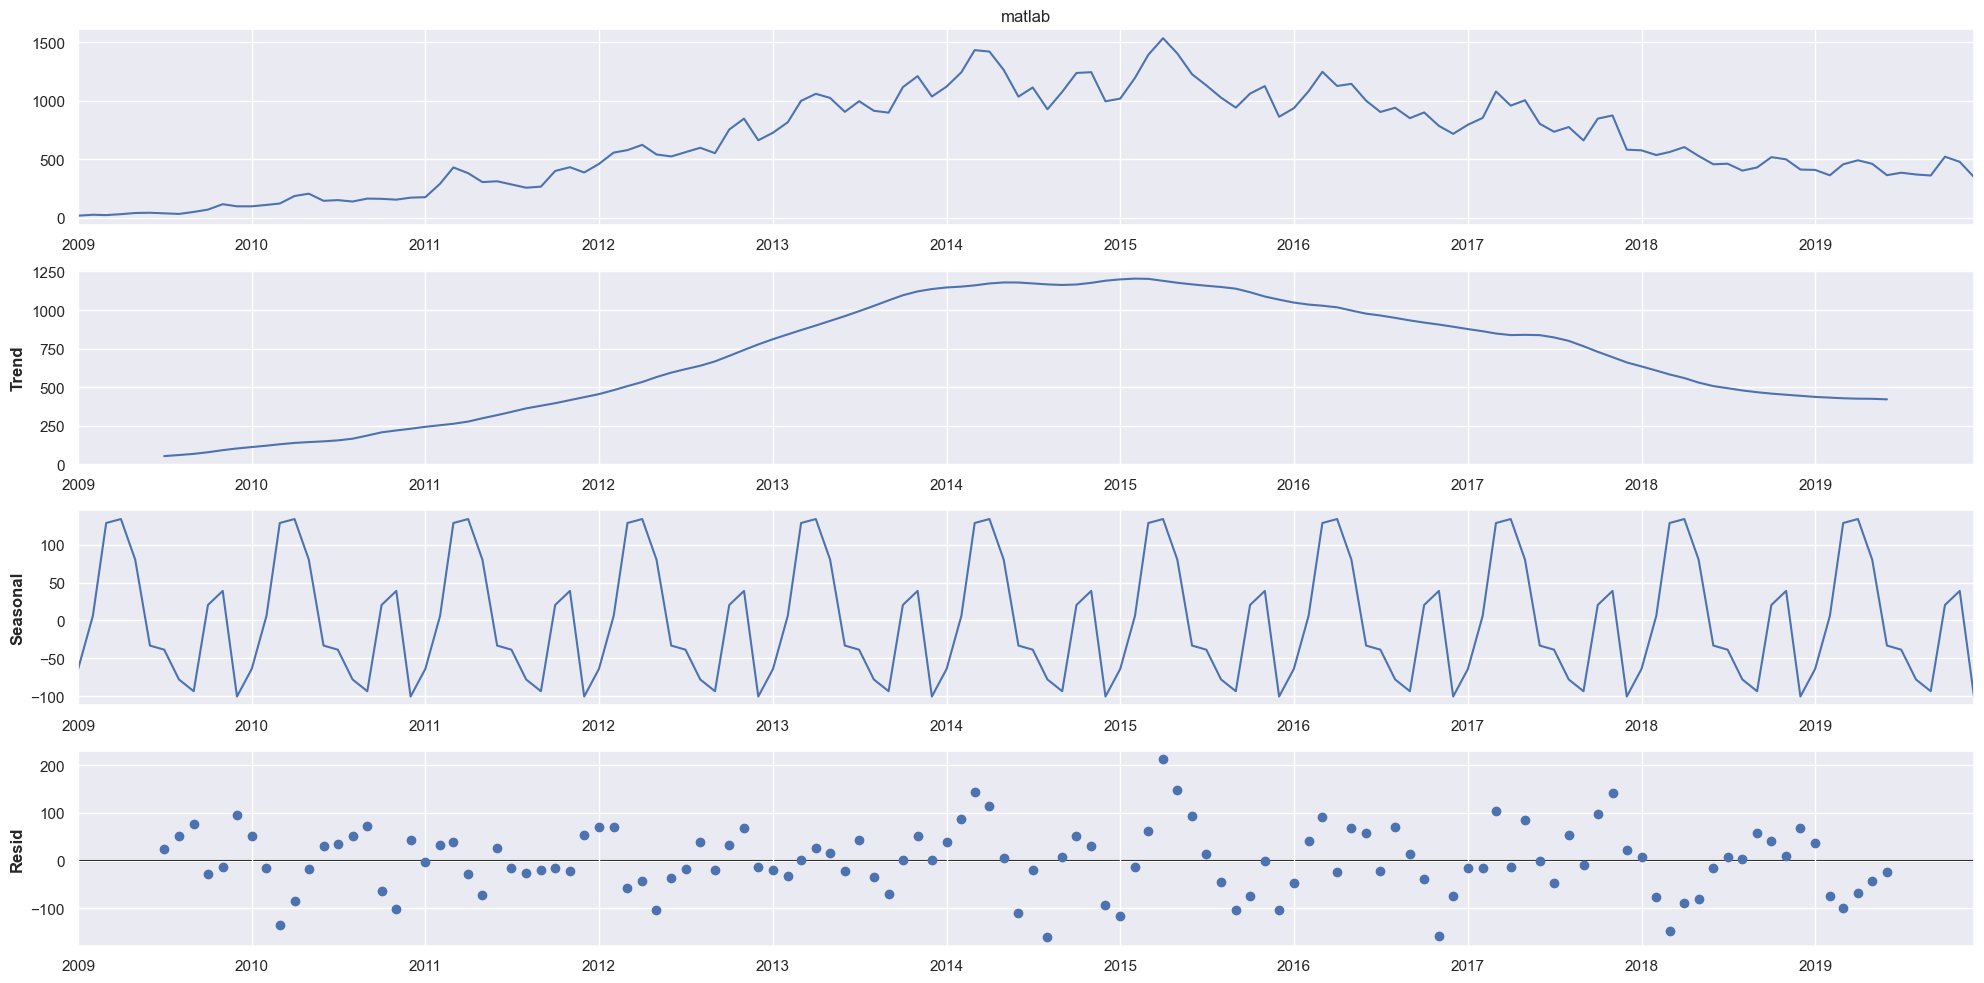

In [8]:
# Decomposition of the time series.

decomposition = seasonal_decompose(stack_df.matlab) # Descomponemos la serie para visualizar la tendencia 

decomposition.plot()


Como hemos comentado anteriormente la gráfica tiene tendencia alcista y bajista a lo largo de los años. Es por ello que no existe estacionalidad en media, y por lo que vemos en la gráfica, la dispersión de los primeros años es mucho más inferior que la de los años próximos por lo que no existe estacionalidad en varianza. 

Sin embargo, comprobamos cierto componente estacional anual, que desarrollaremos en el siguiente punto, descomponiendolo mensulamente.

###  4.1. Análisis de estacionalidad

Observamos la existencia de  un componente estacional anual, por ello vamos a descomponerlo mensualmente para ver como varía.

Text(0.5, 1.0, 'Comportamiento Estacional')

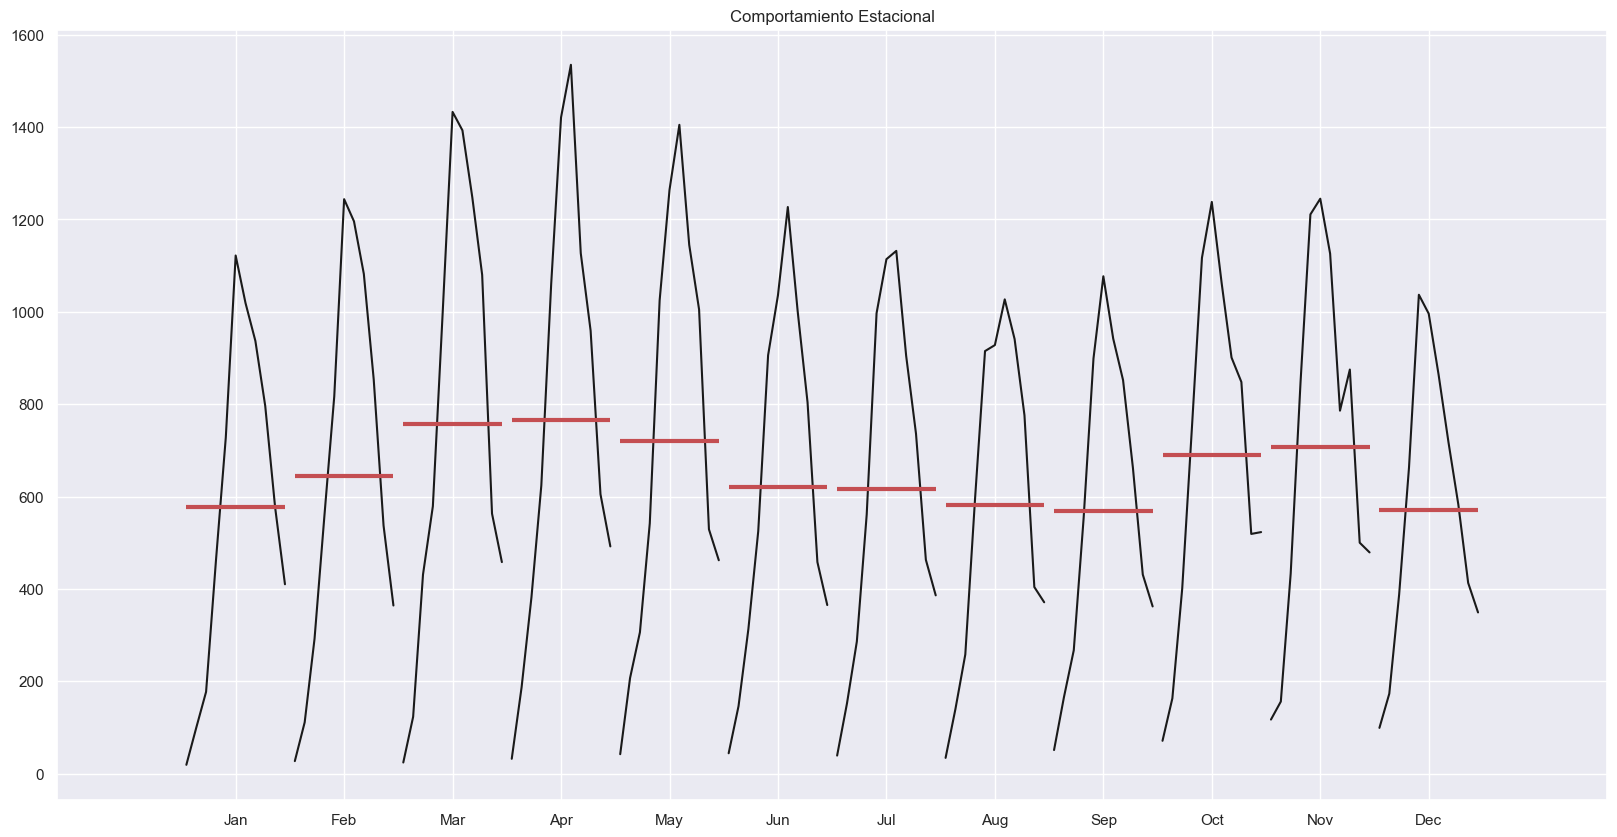

In [8]:
# Plot the stationary series.

ax = plt.gca() # Representamos el componente estacional por meses
sm.graphics.tsa.month_plot(stack_df['matlab'],ax=ax)
ax.set_title('Comportamiento Estacional')

En cuanto al componente estacional, observamos como es practicamente igual entre los diferentes meses del año, con una subida y bajada. Sin embargo, la media de preguntas es superior durante los meses de marzo y abril, mientras que los meses de verano adquiere su media más baja.

Esto se puede deber a que durante los meses antes de vacaciones hay un mayor número de proyectos y por lo tanto dudas. En octubre y noviembre vuelven a incrementar probablemente dado a que tras la vuelta de vacaciones la gente necesite refrescar dudas de como se hacian ciertos procesos o utilizar comandos. 

### <a name="ets">  5.  Modelo ETS - Suavizado Exponencial (Automático) </a>

En primer lugar vamos a probar el modelo ETS automático, por lo que primero separaremos los datos en train y test.

In [9]:
# Split the data into train and test.

y_train, y_test = temporal_train_test_split(y=stack_df['matlab'].to_period('M'), test_size=6) 

Graficamos los dos datasets:

126 6


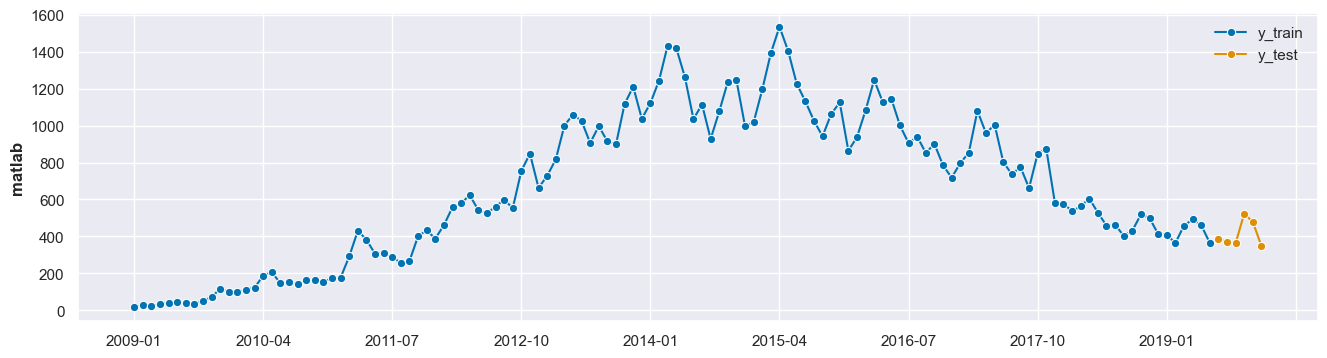

In [10]:
# Plot the train and test data.

plot_series(y_train, y_test, labels=["y_train", "y_test"]) 

# Print the shape of the train and test data.

print(y_train.shape[0], y_test.shape[0])

Creamos el modelo para predecir en un periodo  mensual:

In [11]:
# Create the forecasting horizon, 6 months.

fh = np.arange(1, len(y_test)+1) 

# Select the model with monthly period and n_jobs = -1 to use the entire processor.

stack_auto_model = AutoETS(auto=True, sp=12, n_jobs=-1) 

# Train the model.

stack_auto_model.fit(y_train) 

AutoETS(auto=True, n_jobs=-1, sp=12)

In [12]:
# Print the summary of the model.

print(stack_auto_model.summary())

                                 ETS Results                                  
Dep. Variable:                 matlab   No. Observations:                  126
Model:                       ETS(MAM)   Log Likelihood                -690.953
Date:                Tue, 22 Nov 2022   AIC                           1417.907
Time:                        10:47:17   BIC                           1468.960
Sample:                    01-31-2009   HQIC                          1438.648
                         - 06-30-2019   Scale                            0.015
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.9999      0.107      9.376      0.000       0.791       1.209
smoothing_trend         0.0182      0.022      0.834      0.404      -0.025       0.061
smoothing_season

In [13]:
# Predict the test data.

stack_pred_auto = stack_auto_model.predict(fh)
print(stack_pred_auto)

2019-07    344.539077
2019-08    311.381022
2019-09    313.153998
2019-10    371.188751
2019-11    388.067150
2019-12    316.343059
Freq: M, dtype: float64


(<Figure size 1600x400 with 1 Axes>, <AxesSubplot:ylabel='matlab'>)

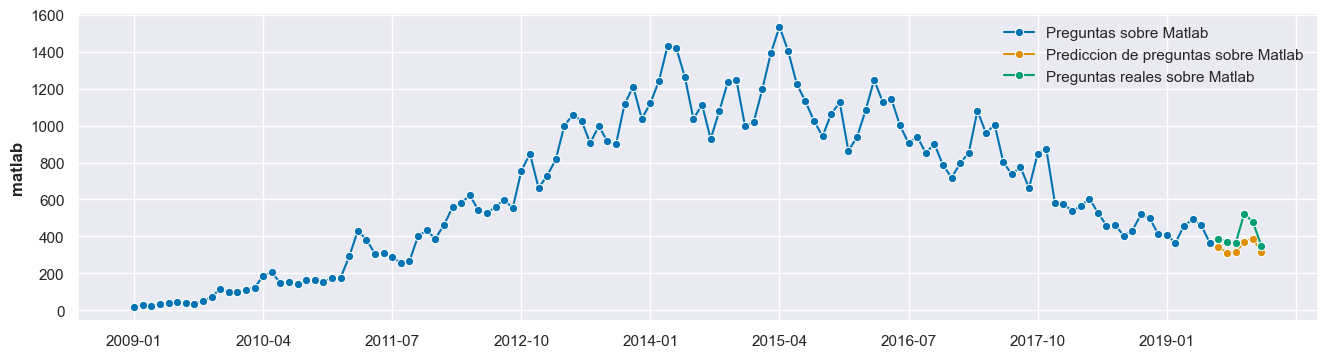

In [14]:
# Plot the real data and the predicted data.

plot_series(y_train, stack_pred_auto,y_test, labels=["Preguntas sobre Matlab", "Prediccion de preguntas sobre Matlab",
                                                     "Preguntas reales sobre Matlab"]) 

In [15]:
# Calculate the errors.

error_abs_per = mean_absolute_percentage_error(y_test, stack_pred_auto) # Error medio porcentual.
mse = MeanSquaredError()
error_mse = mse(y_test, stack_pred_auto) # Error cuadrático medio.
rmse = MeanSquaredError(square_root=True)
error_rmse = rmse(y_test, stack_pred_auto) # Raíz cuadrada del error cuadrado medio 

# Print the errors.

print('El error absoluto medio porcentual es del ' + str(round(error_abs_per *100, 2)) + ' %')
print('El error cuadrático medio es de ' + str(round(error_mse , 2)))
print('La raíz cuadrada del error cuadrático medio es de ' + str(round(error_rmse , 2)))


El error absoluto medio porcentual es del 16.28 %
El error cuadrático medio es de 6673.55
La raíz cuadrada del error cuadrático medio es de 81.69


## <a name="arima">  6. Modelo ARIMA (Autorregresivo integrado de media móvil) </a>

Convertimos los datos del dataset entero a periodo mensual

In [16]:
# Convert the column 'month' to monthly period.

stack_mensual =stack_df['matlab'].to_period('M') 

Realizamos la transformación logarítmica de los datos:

In [17]:
#Logarítmic transformation.

ransformer = LogTransformer()
log_stack_mensual= transformer.fit_transform(stack_mensual)

# Print the last 5 rows.

log_stack_mensual.tail()

month
2019-08    5.916202
2019-09    5.891644
2019-10    6.259581
2019-11    6.171701
2019-12    5.855072
Freq: M, dtype: float64

Representamos la serie original vs la serie transformada a logarítmos.

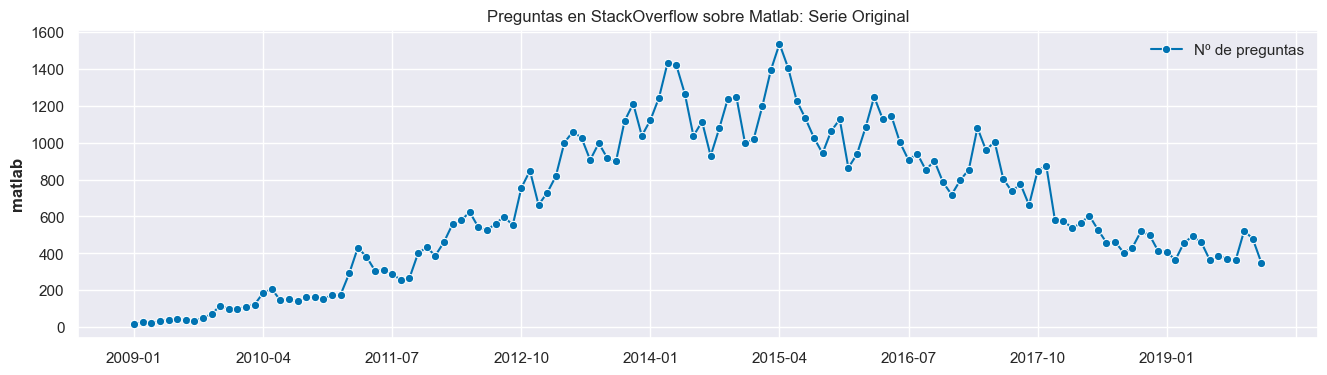

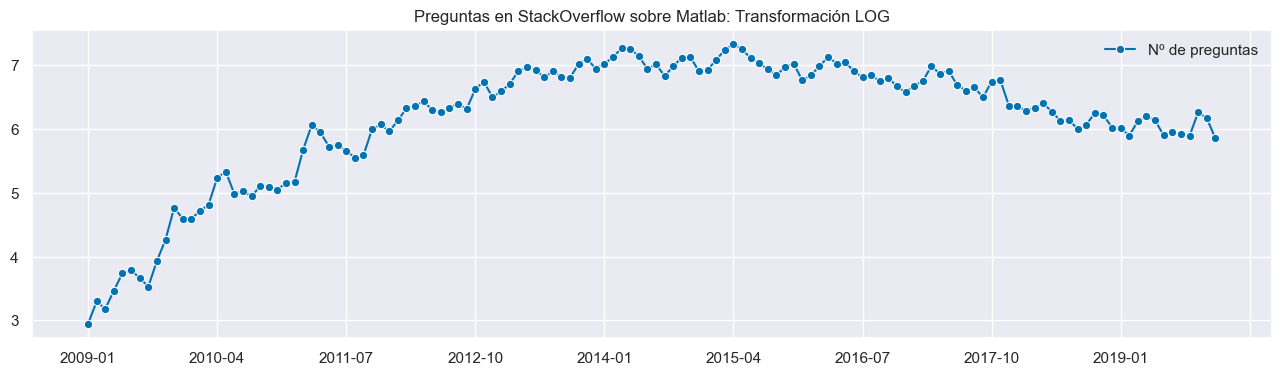

In [18]:
# Plot the original series and the transformed series.

fig, ax =plot_series(stack_mensual, labels=["Nº de preguntas"])

ax.set_title('Preguntas en StackOverflow sobre Matlab: Serie Original');

fig, ax =plot_series(log_stack_mensual, labels=["Nº de preguntas"])

ax.set_title('Preguntas en StackOverflow sobre Matlab: Transformación LOG');

plt.show()

Dividimos los datos en train y test:

In [19]:
# We select the last 6 as test for the logs.

log_y_train, log_y_test = temporal_train_test_split(y=log_stack_mensual, test_size=6)

# Select the last 6 values as test.

y_train, y_test = temporal_train_test_split(y=stack_df['matlab'].to_period('M'), test_size=6) 

Representamos graficamente la división de los dos datasets en la serie logarítmica.

126 6


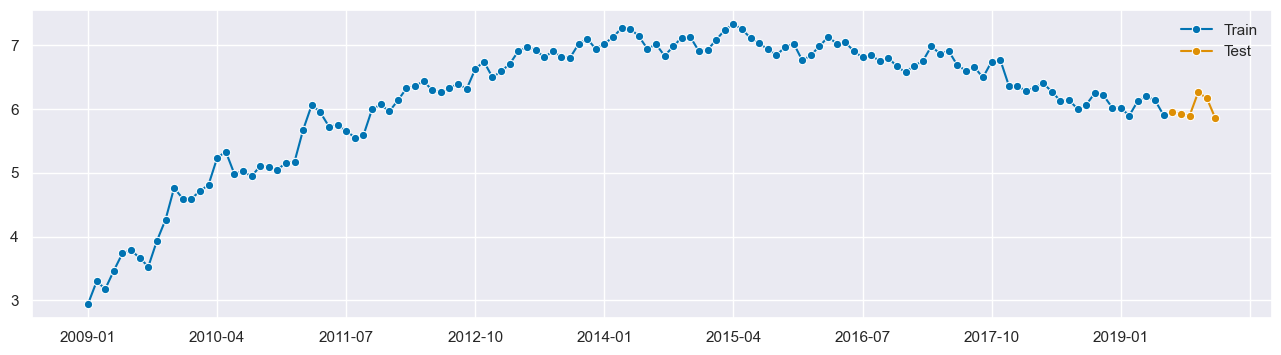

In [20]:
#Plot the train and test data from the logarítmic transformation. 

plot_series(log_y_train, log_y_test, labels=["Train", "Test"])

# Print the shape of the train and test data.

print(y_train.shape[0], y_test.shape[0])

Creamos el modelo:

In [21]:
# Forecasting horizon.

fh = np.arange(1, len(y_test)+1) 

In [22]:
# Create the model.

forecaster = AutoARIMA(sp=12,suppress_warnings=True)

# Train the model.

forecaster.fit(log_y_train)

AutoARIMA(sp=12, suppress_warnings=True)

Observamos el resumen del modelo escogido:

In [23]:
# Print the summary of the model.

print(forecaster.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  126
Model:             SARIMAX(4, 2, 1)x(1, 0, 1, 12)   Log Likelihood                  71.666
Date:                            Tue, 22 Nov 2022   AIC                           -127.332
Time:                                    10:50:05   BIC                           -104.770
Sample:                                01-31-2009   HQIC                          -118.167
                                     - 06-30-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1673      0.088     -1.910      0.056      -0.339       0.004
ar.L2         -0.2631      0.077   

Predecimos los valores de test:

In [24]:
# Predict the test data.

log_y_pred = forecaster.predict(fh)

Transformamos las predicciones logarítmicas para la serie original:

In [92]:
# Transform the predicted data to the original scale.

stack_pred_arima1 = np.exp(log_y_pred)

Graficamos los resultados:

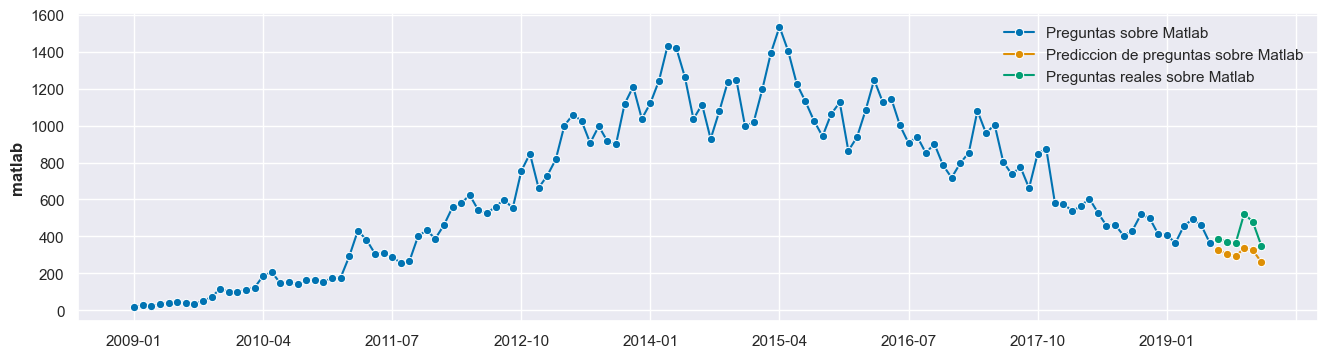

In [93]:
# Plot the real data and the predicted data.

plot_series(y_train, stack_pred_arima1,y_test, labels=["Preguntas sobre Matlab", "Prediccion de preguntas sobre Matlab",
                                                     "Preguntas reales sobre Matlab"])
plt.show()

Observamos como para la predicción ha tenido en cuenta la tendencia descendente de los ultimos años, es por eso que puede ser que haya estimado preguntas por debajo de las reales. Observamos los errores del modelo:

In [27]:
# Calculate the errors.

arima_error_abs_per = mean_absolute_percentage_error(y_test,  stack_pred_arima1) # Error medio porcentual.
mse = MeanSquaredError()
arima_error_mse = mse(y_test, stack_pred_arima1) # Error cuadrático medio.
rmse = MeanSquaredError(square_root=True)
arima_error_rmse = rmse(y_test,  stack_pred_arima1) # Raíz cuadrada del error cuadrado medio 

# Print the errors.

print('El error absoluto medio porcentual es del ' + str(round(arima_error_abs_per *100, 2)) + ' %')
print('El error cuadrático medio es de ' + str(round(arima_error_mse , 2)))
print('La raíz cuadrada del error cuadrático medio es de ' + str(round(arima_error_rmse , 2)))

El error absoluto medio porcentual es del 24.21 %
El error cuadrático medio es de 13205.83
La raíz cuadrada del error cuadrático medio es de 114.92


## <a name="4theta">  7. Modelo 4Theta  </a>

Dado que utiliza librerias diferentes, para realizar este modelo deberemos cargar de nuevo el dataset `StackOverflow.csv` y trabajarlo con arrays.

In [32]:
# Load the data to use it with the darts library.

darts_df = pd.read_csv('../data/StackOverflow.csv', sep = ',') 

# Convert the column 'month' to datetime.

darts_df['month'] = pd.to_datetime(darts_df['month'], format="%y-%b")

Guardamos en `series` la columna de matlab y las fechas en el formato que usará la libreria darts

In [33]:
# Create a dataframe with the darts format.

series = TimeSeries.from_dataframe(darts_df, 'month', 'matlab')

Visualizamos la serie temporal:

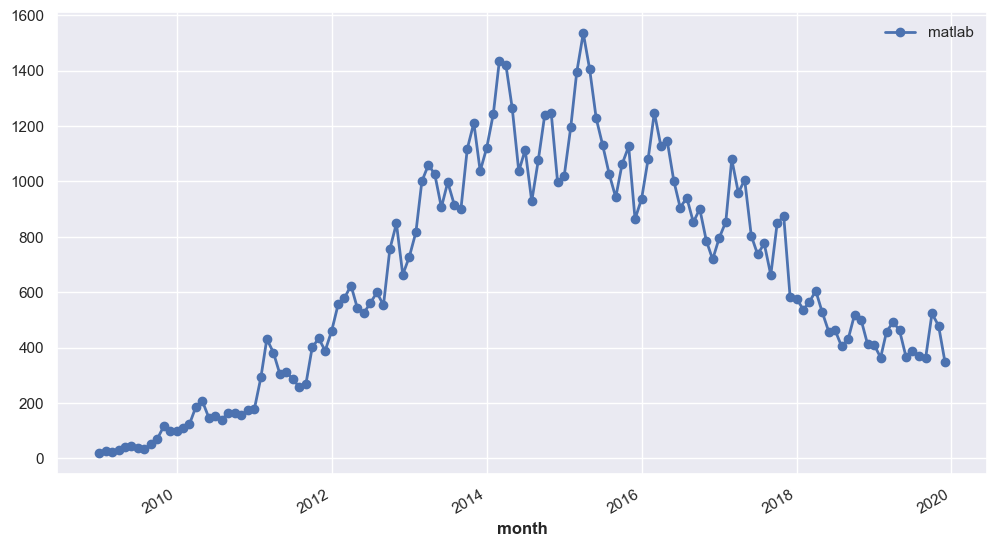

In [34]:
# Plot the data.

plt.rcParams["figure.figsize"] = (12,6)
series.plot(marker='o', linestyle='-')

Dividemos en training, set y validación para entrenar a nuestro modelo. Usaremos el set de validación y train para modificar los hiperparametros e ir ajustando el modelo para aplicarlo finalmente en el set de test.

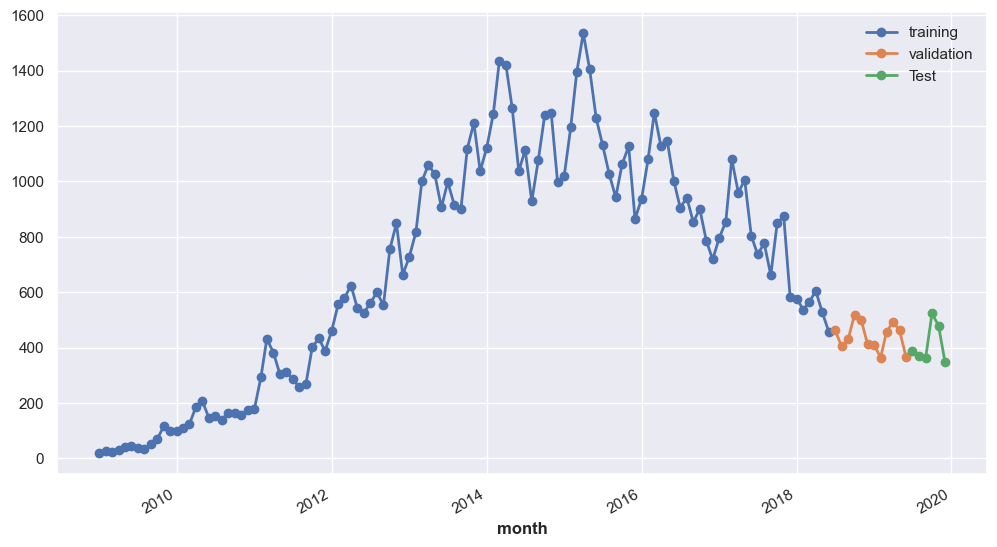

In [35]:
# We choose as test the last 6 values and within the train set we choose the last 12 for the validation set.

series_train_total, series_test =series[:-6], series[-6:]
series_train, series_validation =series_train_total[:-12], series_train_total[-12:]

# Plot the train, validation and test data.

series_train.plot(label="training", marker='o', linestyle='-')
series_validation.plot(label="validation",marker='o', linestyle='-')
series_test.plot(label="Test",marker='o', linestyle='-')


Creamos un bucle que según las características de nuestra serie temporal, probará diferentes hiperparámetros y nos seleccionará el que mejor resultado nos dé en `best_grid_model`. En este caso seleccionamos la agrupación de fechas de train y validación para que vaya recorriendo el forecast de validación durante esa serie temporal.

In [64]:
# Create a grid with the model to use.

theta_grid = {
    'theta':2- np.linspace(-10, 10, 10),
    'model_mode': [ModelMode.ADDITIVE,ModelMode.MULTIPLICATIVE],
    'season_mode': [SeasonalityMode.MULTIPLICATIVE,SeasonalityMode.ADDITIVE],
    'trend_mode': [TrendMode.EXPONENTIAL,TrendMode.LINEAR],
     
}

# Create a grid with the best model.

best_grid_model=FourTheta.gridsearch(parameters=theta_grid,
                                series=series_train,
                                forecast_horizon=12, 
                                start=0.6, 
                                last_points_only=False,
                                metric=mape,
                                reduction=np.mean,
                                stride=1,
                                verbose=False,
                                n_jobs=-1)



In [52]:
# Check the best hyperparameters.

best_grid_model

(<darts.models.forecasting.theta.FourTheta at 0x243c1b5c4f0>,
 {'theta': 0.8888888888888893,
  'model_mode': <ModelMode.ADDITIVE: 'additive'>,
  'season_mode': <SeasonalityMode.ADDITIVE: 'additive'>,
  'trend_mode': <TrendMode.EXPONENTIAL: 'exponential'>},
 18.63853454167994)

Aplicamos a nuestro modelo las características del mejor grid.

In [56]:
# Set up the model with the best hyperparameters.

modelo=FourTheta(theta=best_grid_model[1]['theta'],
                 model_mode=ModelMode.ADDITIVE,
                 season_mode=SeasonalityMode.ADDITIVE,
                 trend_mode=TrendMode.EXPONENTIAL
                 )

# Train the model.

modelo.fit(series_train_total)

Procedemos a predecir con nuestro modelo, los periodos de test.

In [58]:
# Predict the test data.

test_predict = modelo.predict(6)

Representamos graficamente su predicción y error MAPE en funcion de los valores originales de ''test'.

MAPE = 16.09%


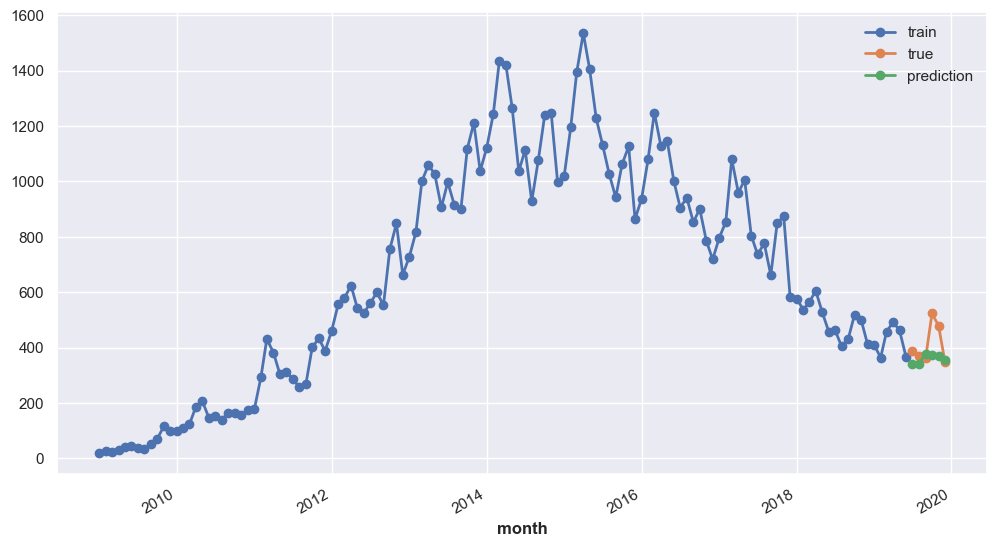

In [59]:
# Print the MAPE.

print("MAPE = {:.2f}%".format(mape(test_predict, series_test)))

# Plot the real data and the predicted data.

series_train_total.plot(label="train",marker='o', linestyle='-')
series_test.plot(label="true",marker='o', linestyle='-')
test_predict.plot(label="prediction",marker='o', linestyle='-')

Con este modelo, **nuestro error MAPE sobre el set de test es del 16.09%**, vemos como el modelo espera un nº de preguntas más modesto de las que hubo en la realidad.

## <a name="tbats">  8. Modelo TBATS  </a>

Procedemos a crear el modelo con el periodo estacional mensual y permitiendo al algoritmo elegir los mejores parametros para optimizar el set de train + validación.

In [86]:
# Set up the model.

model =TBATS(
use_box_cox=None,
box_cox_bounds=(0, 1),
use_trend=None,
use_damped_trend=None,
seasonal_periods=[12],
use_arma_errors=True,
show_warnings=False,
multiprocessing_start_method='spawn',
random_state=12345)

model.fit(series_train_total)

Visualizamos el mejor modelo que se ajusta:

In [87]:
# Check the best hyperparameters.

model.model.params.summary()

'Use Box-Cox: True\nUse trend: True\nUse damped trend: False\nSeasonal periods: [12.]\nSeasonal harmonics [4]\nARMA errors (p, q): (0, 0)\nBox-Cox Lambda 0.575624\nSmoothing (Alpha): 0.731800\nTrend (Beta): 0.041770\nDamping Parameter (Phi): 1.000000\nSeasonal Parameters (Gamma): [ 1.31516020e-07 -3.15248939e-07]\nAR coefficients []\nMA coefficients []\nSeed vector [ 3.62023513  1.87152987  1.10672604 -4.22303091 -1.89909995  0.80224378\n  4.20342617 -0.51672321  0.67266762  1.30258307]\n'

Lo aplicamos y predecimos el valor de test y su MAPE.

In [135]:
# Apply the hyperparameters to the model.

model =TBATS(
use_box_cox=True,
box_cox_bounds=(0, 1),
use_trend=True,
use_damped_trend=False,
seasonal_periods=[30],
use_arma_errors=True,
show_warnings=False,
multiprocessing_start_method='spawn',
random_state=12345)

# Train the model.

model.fit(series_train_total)

# Predict the test data.

forecast = model.predict(len(series_test))

# Print the MAPE.

print("model {} obtains MAPE: {:.2f}%".format(model, mape(series_test, forecast)))

model (T)BATS obtains MAPE: 8.74%


Representamos graficamente la predicción frente a los valores reales de 'test'.

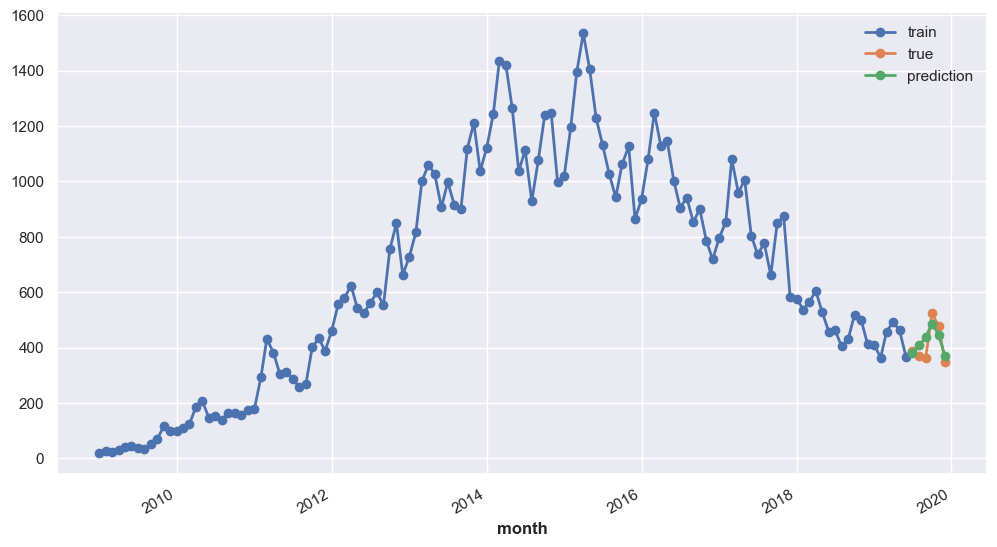

In [136]:
# Plot the real data and the predicted data.

series_train_total.plot(label="train",marker='o', linestyle='-')
series_test.plot(label="true",marker='o', linestyle='-')
forecast.plot(label="prediction",marker='o', linestyle='-')

Con el modelo BATS, **nuestro error MAPE sobre el set de test es del 8.74%**, vemos como el modelo se ajusta mucho mejor a los valores reales de `test` que los otros modelos probados anteriormente.

## <a name="prediccion">  9. Predicción de 12 meses fuera de la muestra  </a>

Una vez testeados los diferentes modelos, realizaremos la predicción de 12 meses fuera de la muestra con aquel que menor error nos ha proporcionado : El modelo TBATS

El error absoluto medio porcentual del AUTOETS es del 16.28 %
El error absoluto medio porcentual del AUTOARIMA es del 24.21 %
El error absoluto medio porcentual del 4Theta es del 13.15%
El error absoluto medio porcentual del (T)BATS es del  MAPE: 8.74%


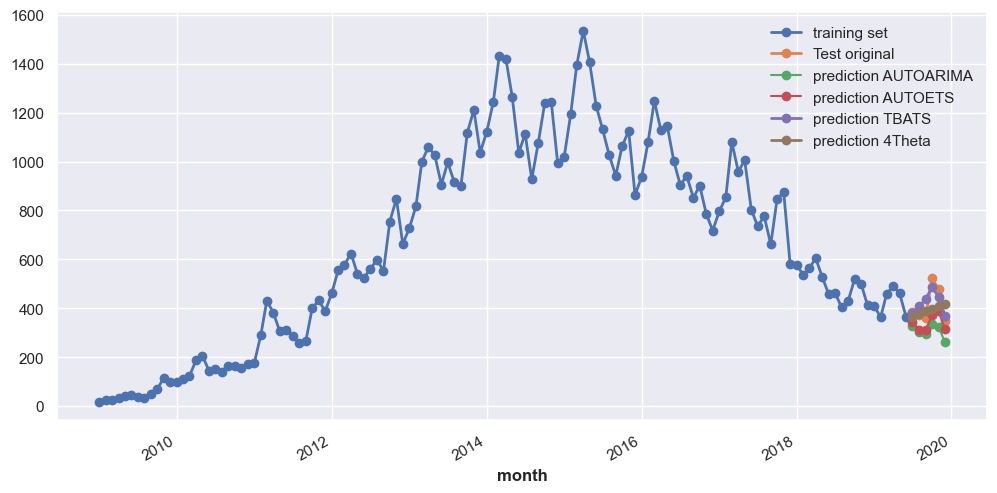

In [143]:
# Plot all the models with the real data and the predicted data.

series_train_total.plot(label="training set",marker='o', linestyle='-')
series_test.plot(label="Test original",marker='o', linestyle='-')
stack_pred_arima1.plot(label="prediction AUTOARIMA",marker='o', linestyle='-')
stack_pred_auto.plot(label="prediction AUTOETS",marker='o', linestyle='-')
forecast.plot(label="prediction TBATS",marker='o', linestyle='-')
test_predict.plot(label="prediction 4Theta",marker='o', linestyle='-')

# Print the error of each model.

print('El error absoluto medio porcentual del AUTOETS es del ' + str(round(error_abs_per *100, 2)) + ' %')
print('El error absoluto medio porcentual del AUTOARIMA es del ' + str(round(arima_error_abs_per *100, 2)) + ' %')
print("El error absoluto medio porcentual del 4Theta es del {:.2f}%".format(mape(test_predict, series_test)))
print("El error absoluto medio porcentual del {} es del  MAPE: {:.2f}%".format(model, mape(series_test, forecast)))

Creamos el modelo con todos los valores de la serie para ser entrenado:

In [146]:
# Set up the model for the next 12 months.

model =TBATS(
use_box_cox=None,
box_cox_bounds=(0, 1),
use_trend=None,
use_damped_trend=None,
seasonal_periods=[12], # Mensual
use_arma_errors=True,
show_warnings=False,
multiprocessing_start_method='spawn',
random_state=12345)

# Train the model.

model.fit(series)

Predecimos los próximos 12 meses:

In [147]:
# Predict the next 12 months.

forecast = model.predict(12)

Representamos graficamente la predicción:

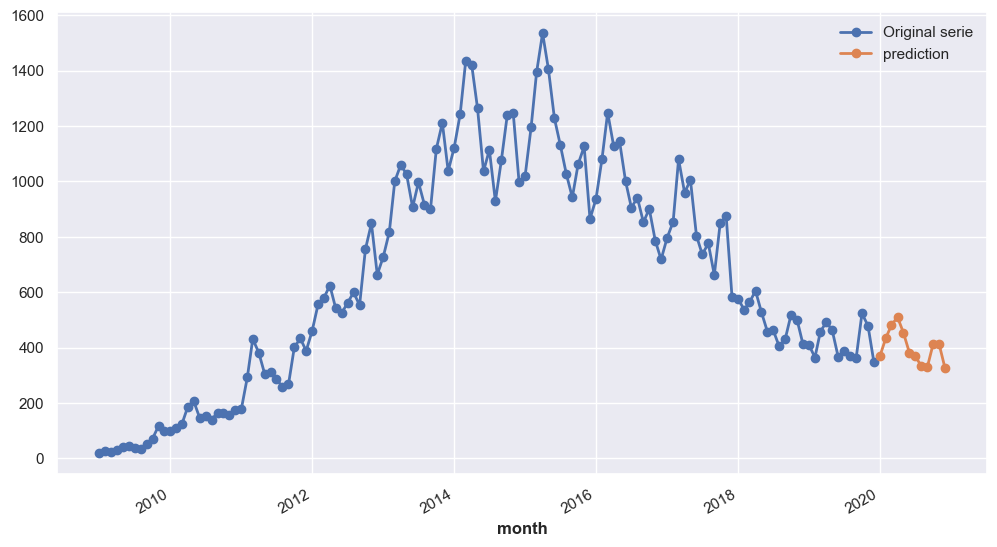

In [148]:
# Plot the real data and the predicted data.

series.plot(label="Original serie",marker='o', linestyle='-')
forecast.plot(label="prediction",marker='o', linestyle='-')

Observamos las predicciones numéricas:

In [150]:
# Print the forecast.

print(forecast)


<TimeSeries (DataArray) (month: 12, component: 1, sample: 1)>
array([[[368.38051485]],

       [[434.85127909]],

       [[481.19710647]],

       [[510.09407161]],

       [[454.36314841]],

       [[382.02613484]],

       [[368.76199383]],

       [[334.28710258]],

       [[328.20587886]],

       [[411.92517307]],

       [[412.59339785]],

       [[327.13257243]]])
Coordinates:
  * month      (month) datetime64[ns] 2020-01-01 2020-02-01 ... 2020-12-01
  * component  (component) object 'matlab'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None


 ## <a name="conclusiones">  10. Conclusiones Generales  </a>

- **Tras estudiar la serie temporal del número de preguntas acerca de MATLAB en StackOverflow, observamos que hasta 2015 tuvo una tendencia alcista y a partir de ese año se volvió bajista. Además no existe estacionalidad ni en media ni en varianza.** 


- **Existe un componente estacional anual, con mayor media durante los meses antes de verano y en la vuelta de vacaciones.**


- **Tras la realización de los diferentes modelos, el que menor MAPE nos ha mostrado ha sido el TBATS.**


- **La predicción de los 12 meses furea de la muestra continua con una tendencia descendente del nº de preguntas acerca de MATLAB.**

[Ir arriba del documento](#top)